# Layer Normalization
Lợi ích:
+ Hữu ích trong các mô hình RNN, nơi mà kích thước batch có thể thay đổi và BN không hoạt động hiệu quả.
+ Có thể làm việc tốt hơn trong các tình huống có batch size nhỏ

So Sánh:
+ Batch Normalization: Thực hiện chuẩn hóa dựa trên trung bình và phương sai của một batch. Hiệu quả hơn khi batch size lớn.
+ Layer Normalization: Thực hiện chuẩn hóa dựa trên các đặc trưng của một mẫu dữ liệu. Thích hợp hơn cho các mô hình với batch size nhỏ hoặc dữ liệu tuần tự. 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler


In [2]:
data = pd.read_csv('heart_failure_clinical_records_dataset.xls')
data.head()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,75.0,0,582,0,20,1,265000.00,1.9,130,1,0,4,1
1,55.0,0,7861,0,38,0,263358.03,1.1,136,1,0,6,1
2,65.0,0,146,0,20,0,162000.00,1.3,129,1,1,7,1
3,50.0,1,111,0,20,0,210000.00,1.9,137,1,0,7,1
4,65.0,1,160,1,20,0,327000.00,2.7,116,0,0,8,1


In [3]:
X = data.drop(columns ='DEATH_EVENT').values
y = data['DEATH_EVENT'].values

In [4]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [5]:
import torch 
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import torch.optim as optim

In [6]:
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(MLP, self).__init__()
        self.z1 = nn.Linear(input_size, hidden_size)
        self.ln1 = nn.LayerNorm(hidden_size)  # Layer Normalization
        self.z2 = nn.Linear(hidden_size, hidden_size)
        self.ln2 = nn.LayerNorm(hidden_size)  # Layer Normalization
        self.z3 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = F.relu(self.ln1(self.z1(x)))  
        x = F.relu(self.ln2(self.z2(x)))  
        x = self.z3(x)
        return x


In [7]:
num_sample, input_size = X_train.shape
hidden_size = 100
output_size = 2
batch_sizes = [4, 8, 12, 24, 32]
num_epochs = [40, 80, 100, 200, 500]


def train(num_epoch, batch_size):
    device = torch.device('cpu')
    train_dataset = TensorDataset(torch.tensor(X_train, dtype=torch.float), torch.tensor(y_train, dtype=torch.long))
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    model = MLP(input_size, hidden_size, output_size).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr = 0.001)

    for epoch in range(num_epoch):
        for X_batch, y_batch in train_dataloader:
            batch_X, batch_y = X_batch.to(device), y_batch.to(device)
            
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            
            # Backward pass và tối ưu hóa
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

    model.eval()
    with torch.no_grad():
        test_X, test_y = torch.tensor(X_test, dtype=torch.float), torch.tensor(y_test, dtype=torch.long)
        outputs = model(test_X)
        _, predicted = torch.max(outputs, 1)
        
        accuracy = (predicted == test_y).sum().item() / test_y.size(0)
    
        return 1 - accuracy


In [8]:
errors = []
for batch_size in batch_sizes:
    error = []
    for num_epoch in num_epochs:
        error.append(train(num_epoch, batch_size))
    errors.append(error)

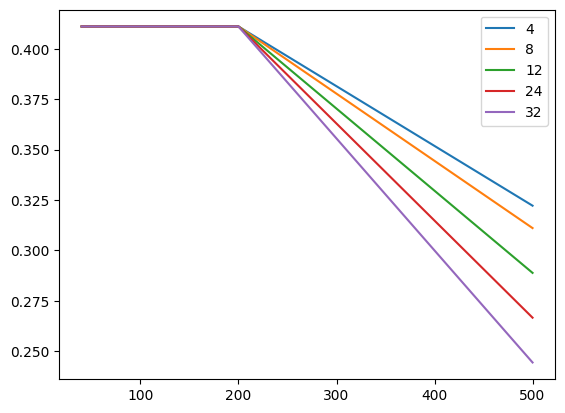

In [9]:
for error, batch_size in zip(errors, batch_sizes):
    plt.plot(num_epochs, error, label=batch_size)

plt.legend(loc="upper right")